In [2]:
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import pandas as pd
import numpy as np
import infomap
import json
from TweetMiner import TweetMiner

In [13]:
# Inherit from TweetMiner for load in JSON

class Graph_Analysis(TweetMiner):
    def __init__(self):
        pass    
    
    def load_graph(self, path):
        G = nx.read_gexf(path)
        
        Nodes_list = list(G.nodes)
        Edges_list = list(G.edges)
        
        print("Nodes Number: ", len(Nodes_list))
        print("Edges Number: ", len(Edges_list))
        
        return G
    
    def set_weight(self, G, WQ=None, w_1=1, w_2=2, w_3=4):
        
        if WQ==None:
            try:
                WQ=self.load_json('Weight_quantity.json')
            except:
                raise Exception("Please input Weight Quantity!")

        # Initialize edegs weight
        for edge in list(G.edges):
            G.edges[edge]['weight'] = 1

        for node in list(G.nodes):
            Suc_set = set(G.successors(node))
            Suc_list = list(G.successors(node))

            # w_1 * RT_ab
            for rt_node in WQ[node]['retweet']:
                if rt_node in Suc_set:
                    G.edges[(node, rt_node)]['weight'] += w_1

            # w_2 * QT_ab
            for qt_node in WQ[node]['quoted']:
                if qt_node in Suc_set:
                    G.edges[(node, qt_node)]['weight'] += w_2

            # w_3 * RP_ab
            for rp_node in WQ[node]['reply']:
                if rp_node in Suc_set:
                    G.edges[(node, rp_node)]['weight'] += w_3
                    
    def community_detection(self, G, percentage=None):
        nx.write_pajek(G, "CD_graph.net")
        im = infomap.Infomap()
        im.read_file("CD_graph.net")
        im.run("-N5")

        for node_id, module_id in im.modules:
            G.nodes[im.get_name(node_id)]['module_id']= module_id

        print("codelength: ",im.codelength)
        print("Number of Modules: ", im.num_top_modules)
        
#        ***********************************************************
        
        # Dictionary
        Community_dict = {}
        module_id_set = set()
        for node_id, module_id in im.modules:
            if module_id in module_id_set:
                Community_dict[module_id].append(im.get_name(node_id))
            else:
                Community_dict[module_id] = [im.get_name(node_id)]
                module_id_set.add(module_id)

        module_id_list = []
        module_size_list = []
        for module_id, module_list in Community_dict.items():
            module_id_list.append(module_id)
            module_size_list.append(len(module_list))

        # DataFrame
        
        Community_df = pd.DataFrame({"Module_id":module_id_list, "Size":module_size_list})
#         Community_df.set_index("Module_id", inplace=True)
        Community_df['Proportion'] = Community_df['Size'] / G.number_of_nodes()
        Community_df['Proportion'] = pd.Series([round(val,2) for val in Community_df['Proportion']], index = Community_df.index)
        
        if percentage==True:
            Community_df['Proportion'] = pd.Series(["{0:.2f}%".format(val * 100) for val in Community_df['Proportion']], index = Community_df.index)
        
        return G, Community_df
    
    def community_dataframe(self, G):
        df = pd.DataFrame()

        nodes_list = []

        weight_list = []
        module_id_list = []

        for node in G.nodes:
            nodes_list.append(node)
            weight_list.append(G.nodes[node]['weight'])
            module_id_list.append(str(G.nodes[node]['module_id']))
    
        df['Node_Weight'] = weight_list
        df['Module_id'] = module_id_list
        df['Name'] = nodes_list
        df.set_index('Name',inplace=True)
        
        return df
    
    def centrality_analysis(self,G):
        
        df = pd.DataFrame()
        nodes_list = []

        for node in G.nodes:
            nodes_list.append(node)
            
        df['Name'] = nodes_list
        df.set_index('Name',inplace=True)
        
        
        # Degree

        In_degree_dict = nx.in_degree_centrality(G)
        Out_degree_dict = nx.out_degree_centrality(G)
        
        # Clustering Coefficient 

        Clustering_dict = nx.algorithms.cluster.clustering(G)
        
        # Page rank

        Page_rank_dict = nx.pagerank(G)
        
        # Save
        
        df['In_Degree'] = [np.nan]*len(df)
        df['Out_Degree'] = [np.nan]*len(df)
        df['Clustering'] = [np.nan]*len(df)
        df['Page_Rank'] = [np.nan]*len(df)

        for index, row in df.iterrows():
    
            df.loc[index,'In_Degree'] = In_degree_dict[index]
            df.loc[index,'Out_Degree'] = Out_degree_dict[index]
            df.loc[index,'Clustering'] = Clustering_dict[index]
            df.loc[index,'Page_Rank'] = Page_rank_dict[index]

        # Format

        cols = ['In_Degree','Out_Degree','Clustering','Page_Rank']
        df = df[cols]

        df['In_Degree'] = pd.Series([round(val,2) for val in df['In_Degree']], index = df.index)
        df['Out_Degree'] = pd.Series([round(val,2) for val in df['Out_Degree']], index = df.index)
        df['Clustering'] = pd.Series([round(val,2) for val in df['Clustering']], index = df.index)
        df['Page_Rank'] = pd.Series([round(val,4) for val in df['Page_Rank']], index = df.index)

        return df
    
    def overall_analysis(self,G):
        
        Reciprocity = nx.reciprocity(G)
        Density = nx.density(G)
        print("Is strongly connected or not: ",nx.is_strongly_connected(G))
        
        results = {}
        
        results["Reciprocity"] = Reciprocity
        results["Density"] = Density
 
        return results

    def strong_connection_analysis(self, G):
        Components_list = list(nx.strongly_connected_components(G))
        G_conden = nx.condensation(G,Components_list)

        comp_list = []
        comp_number_list = []
        size_list = []
        for comp in G_conden.nodes:
            members = list(G_conden.nodes[comp]['members'])
            comp_list.append(comp)
            comp_number_list.append(members)
            size_list.append(len(members))

        # Save results

        Condensation_df = pd.DataFrame({"Component":comp_list, "Size":size_list,
                                        "Members":comp_number_list,
                                       "Connection":[(4,0),(4,1),(4,2),(4,3),"None"]})
        Condensation_df.set_index('Component',inplace=True) 
        
        
        # Find the bridge between each componets

        Bridge = {}
        for edge in G_conden.edges:
            pre_members = set(G_conden.nodes[edge[0]]['members'])
            suc_members = list(G_conden.nodes[edge[1]]['members'])

            bridge_list = []
            for node in suc_members:
                node_pre_list = list(G.predecessors(node))
                for node_pre in node_pre_list:
                    if node_pre in pre_members:
                        bridge_list.append((node_pre, node))           
            Bridge[edge] = bridge_list

        bridge_num_list = []
        for edge in G_conden.edges:
            bridge_num_list.append(len(Bridge[edge]))

        Condensation_df["Number of bridges"] = bridge_num_list + ['None']
        
        return Condensation_df

In [14]:
A = Graph_Analysis()

In [15]:
# Load in Graph

G = A.load_graph('Ego_1.5_Graph_HuXijin_GT.gexf')

Nodes Number:  492
Edges Number:  28148


In [6]:
# Perform Overall and Centrality Analysis

# overall
overall_dict = A.overall_analysis(G)
print(overall_dict)

# Centrality
df = A.centrality_analysis(G)
df.head()

Is strongly connected or not:  False
{'Reciprocity': 0.42368907204774764, 'Density': 0.11652012650472737}


,In_Degree,Out_Degree,Clustering,Page_Rank
Name,,,,
HuXijin_GT,0.84,1.00,0.11,0.0070
KellyCNBC,0.02,0.02,0.42,0.0009
howardfineman,0.02,0.05,0.32,0.0004
suhasinih,0.11,0.12,0.22,0.0030
Tom_Winter,0.02,0.03,0.28,0.0005


In [7]:
# This is result of centrality analysis for 2-degree ego grap 

df_2 = pd.read_csv('G2_centrality.csv')
df_2.head()

,Name,In Degree,Out Degree,Clustering,Page Rank
0,2775998016,0.001768,0.002107,0.110575,0.000006
1,1164674447506386944,0.000051,0.001060,0.011869,0.000004
2,14962779,0.000039,0.009198,0.001164,0.000004
3,25966181,0.000227,0.008898,0.004576,0.000004
4,27101698,0.000039,0.009623,0.000391,0.000004


In [10]:
# Set the weitght coefficient

A.set_weight(G, w_1=1, w_2=5, w_3=10)

In [11]:
# Perform community detection 

G_cd, Community_df = A.community_detection(G)
Community_df.head()

codelength:  6.483275092631919
Number of Modules:  37


,Module_id,Size,Proportion
0,1,133,0.27
1,19,11,0.02
2,2,38,0.08
3,10,33,0.07
4,23,4,0.01


In [23]:
# Display the nodes weight and module_id by node 

df_cd = A.community_dataframe(G_cd)
df_cd.head()

,Node_Weight,Module_id
Name,,
HuXijin_GT,1936,1
KellyCNBC,1773,19
howardfineman,3245,2
suhasinih,3218,10
Tom_Winter,3230,19


In [16]:
# Perform strong connection analysis

df_st = A.strong_connection_analysis(G)
df_st

,Size,Members,Connection,Number of bridges
Component,,,,
0,1,[iingwen],"(4, 0)",25
1,1,[ftchina],"(4, 1)",124
2,1,[theresa_may],"(4, 2)",32
3,1,[RahulGandhi],"(4, 3)",202
4,488,"[eosnos, heidirediker, EdmondLococo, beijingbo...",None,None


In [18]:
# Generate Subgraph and perform eccentricity analysis

sub_nodes_list = df_st.loc[4,'Members']
G_sub = G.subgraph(sub_nodes_list)

Eccen = nx.eccentricity(G_sub)

Eccen_list = []
for index, row in df.iterrows():
    try:
        Eccen_list.append(Eccen[index])
    except KeyError:
        Eccen_list.append(np.nan)

In [19]:
# Add eccentricity to the centrality 

df['Eccentricity'] = Eccen_list
df.head()

,In_Degree,Out_Degree,Clustering,Page_Rank,Eccentricity
Name,,,,,
HuXijin_GT,0.84,1.00,0.11,0.0070,1.0
KellyCNBC,0.02,0.02,0.42,0.0009,2.0
howardfineman,0.02,0.05,0.32,0.0004,2.0
suhasinih,0.11,0.12,0.22,0.0030,2.0
Tom_Winter,0.02,0.03,0.28,0.0005,2.0


In [29]:
# Invoing results of community detection in DataFrame

df_final = pd.merge(df, df_cd, on='Name')
cols = ['Node_Weight','Module_id','In_Degree','Out_Degree','Clustering','Page_Rank','Eccentricity']
df_final = df_final[cols]
df_final.head()

,Node_Weight,Module_id,In_Degree,Out_Degree,Clustering,Page_Rank,Eccentricity
Name,,,,,,,
HuXijin_GT,1936,1,0.84,1.00,0.11,0.0070,1.0
KellyCNBC,1773,19,0.02,0.02,0.42,0.0009,2.0
howardfineman,3245,2,0.02,0.05,0.32,0.0004,2.0
suhasinih,3218,10,0.11,0.12,0.22,0.0030,2.0
Tom_Winter,3230,19,0.02,0.03,0.28,0.0005,2.0


array([[<AxesSubplot:title={'center':'Clustering'}>,
        <AxesSubplot:title={'center':'Eccentricity'}>,
        <AxesSubplot:title={'center':'In_Degree'}>],
       [<AxesSubplot:title={'center':'Node_Weight'}>,
        <AxesSubplot:title={'center':'Out_Degree'}>,
        <AxesSubplot:title={'center':'Page_Rank'}>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

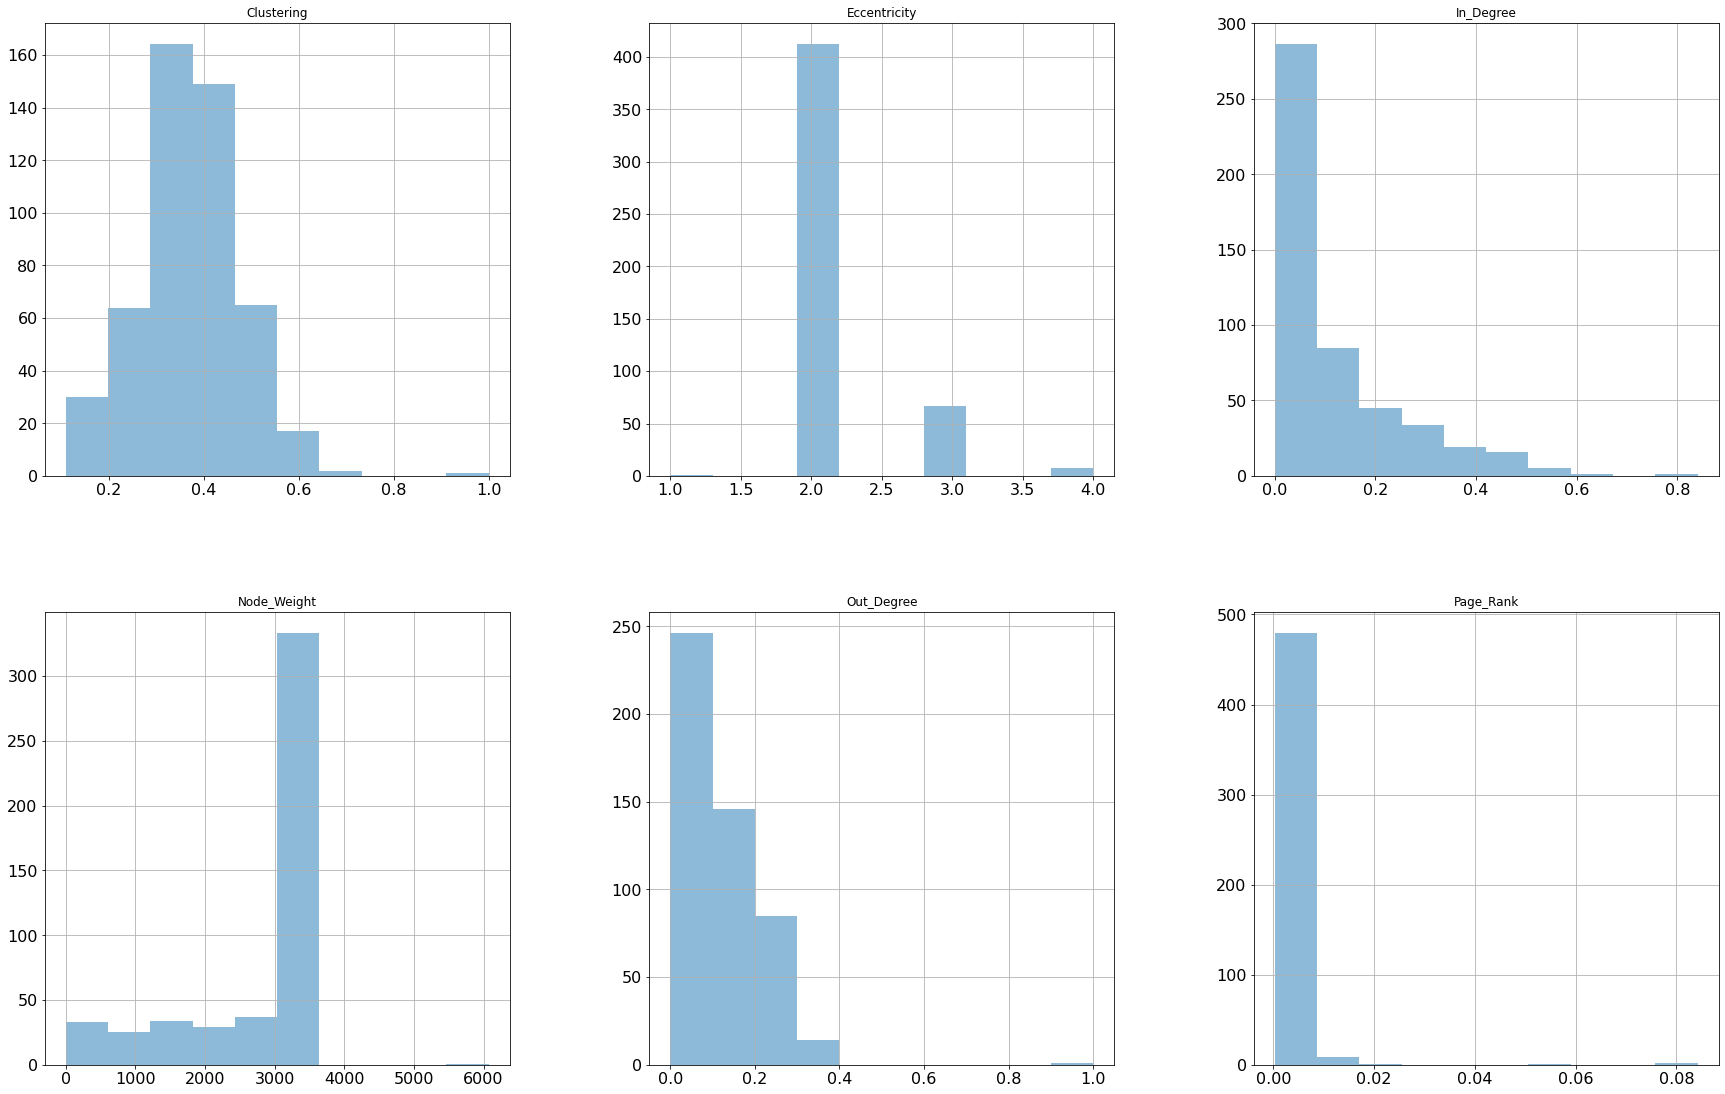

In [38]:
# Plot all the Attribute.

df_final.hist(layout=(3,3),figsize=(30,30), xlabelsize=16, ylabelsize=16, alpha=0.5)

# colorful version is available

# df_final.hist(column="Node_Weight", layout=(3,3),figsize=(16,14), xlabelsize=10, ylabelsize=10, alpha=0.5, color='r')
# df_final.hist(column="In_Degree", layout=(3,3),figsize=(16,14), xlabelsize=10, ylabelsize=10, alpha=0.5, color='g')
# df_final.hist(column="Out_Degree", layout=(3,3),figsize=(16,14), xlabelsize=10, ylabelsize=10, alpha=0.5, color='b')
# df_final.hist(column="Clustering", layout=(3,3),figsize=(16,14), xlabelsize=10, ylabelsize=10, alpha=0.5, color='m')
# df_final.hist(column="Page_Rank", layout=(3,3),figsize=(16,14), xlabelsize=10, ylabelsize=10, alpha=0.5, color='k')
# df_final.hist(column="Eccentricity", layout=(3,3),figsize=(16,14), xlabelsize=10, ylabelsize=10, alpha=0.5, color='c')

In [ ]:
# Plot the results of community detection

ax = Community_df.plot.bar(x='Module_id', y='Proportion', rot=0,figsize=(8,6), alpha=0.5, color='g')

codelength:  6.483275092631919
Number of Modules:  37


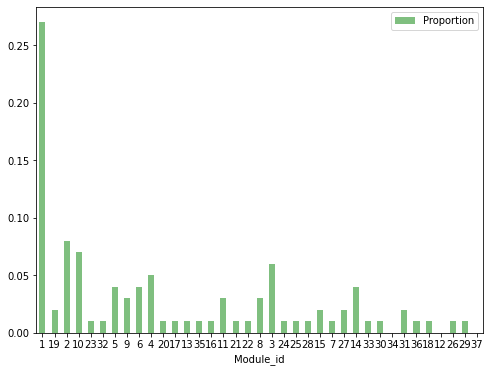

In [36]:
# Set different weight and plot corresponding results

A.set_weight(G, w_1=1, w_2=5, w_3=10)
G_cd, Community_df = A.community_detection(G)
ax = Community_df.plot.bar(x='Module_id', y='Proportion', rot=0,figsize=(8,6), alpha=0.5, color='g')

In [37]:
# Output the graph after communiy detection

nx.write_gexf(G_cd, "Community_Detection.gexf")